# ***Data Science & HPC 2nd Project***

## ***Initializing and Importing Packages***

In [502]:
using Plots, DataFrames, AlphaVantage, StatsBase, SpecialFunctions, Dates, Plots.PlotMeasures, Combinatorics, Statistics, LaTeXStrings, CSV
using IJulia: readprompt
theme(:dark)
Plots.default(titlefontsize=12, tickfontsize=10, labelfontsize=12, legendfontsize=9,
    fontfamily="Computer Modern", frame=:box, label=nothing)

In [107]:
client = AlphaVantage.GLOBAL[]
client.key = "TXEE829JQ3ADBV6U"

"TXEE829JQ3ADBV6U"

## ***Problem 1:***

### Defining required functions

In [108]:
function GetData(TikName::String, SMLength::Integer)
    Data = digital_currency_daily(TikName, "USD", datatype="csv")[1][:, [1, 2, 3, 4, 5, 10, 11]]
    CurrDF = DataFrame("Timestamp" => Date.(Data[:, 1]),
        "Open (USD)" => Float64.(Data[:, 2]),
        "High (USD)" => Float64.(Data[:, 3]),
        "Low (USD)" => Float64.(Data[:, 4]),
        "Close (USD)" => Float64.(Data[:, 5]),
        "Volume" => Float64.(Data[:, 6]),
        "Market Cap (USD)" => Float64.(Data[:, 7]))
    DateSpan = findall(x -> x <= Date("2022-04-01") && x >= Date("2022-04-01") - Month(SMLength), CurrDF.Timestamp)
    return sort(CurrDF[DateSpan, :], "Timestamp")
end

function GetScaledData(df::DataFrame)
    ScaledClose = (df."Close (USD)" .- mean(df."Close (USD)")) / std(df."Close (USD)")
    CumRet = cumprod(df."Close (USD)" ./ df."Open (USD)") .- 1
    return [df.Timestamp, ScaledClose, CumRet]
end

GetScaledData (generic function with 1 method)

### Exporting required data

In [109]:
Currencies = String["BTC", "ETH", "XRP", "SOL", "LUNA"];
TotalData = [GetData(Curr, 12) for Curr ∈ Currencies];
TotalScaledData = [GetScaledData(df) for df ∈ TotalData];

### Plotting the results

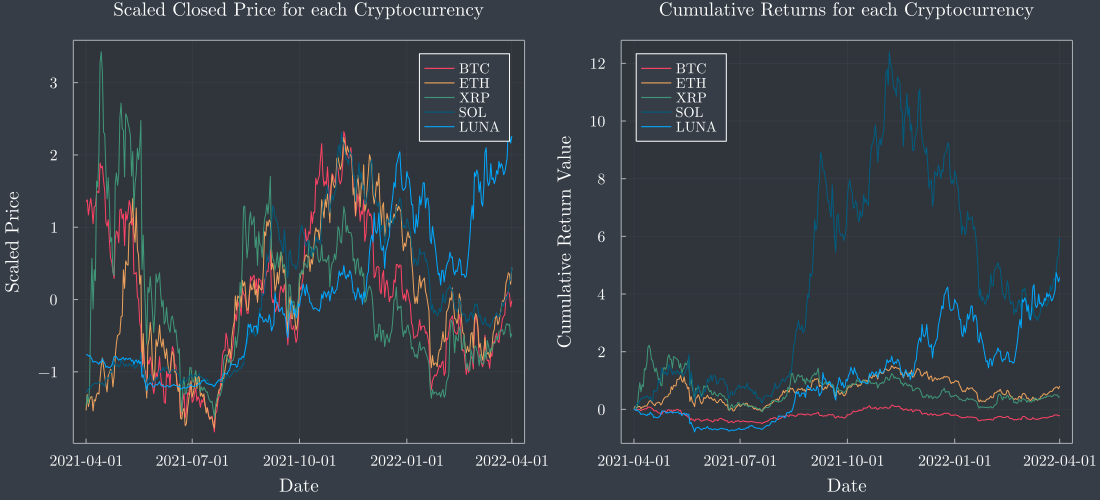

In [110]:
CUMRETPLT = begin
    plot(title="Cumulative Returns for each Cryptocurrency", legend = :topleft, xlab = "Date", ylab = "Cumulative Return Value")
    plot!(TotalScaledData[1][1], TotalScaledData[1][3], label ="BTC")
    plot!(TotalScaledData[2][1], TotalScaledData[2][3], label="ETH")
    plot!(TotalScaledData[3][1], TotalScaledData[3][3], label="XRP")
    plot!(TotalScaledData[4][1], TotalScaledData[4][3], label="SOL")
    plot!(TotalScaledData[5][1], TotalScaledData[5][3], label="LUNA")
end

PRICEPLT = begin
    plot(title="Scaled Closed Price for each Cryptocurrency", xlab = "Date", ylab = "Scaled Price")
    plot!(TotalScaledData[1][1], TotalScaledData[1][2], label ="BTC")
    plot!(TotalScaledData[2][1], TotalScaledData[2][2], label="ETH")
    plot!(TotalScaledData[3][1], TotalScaledData[3][2], label="XRP")
    plot!(TotalScaledData[4][1], TotalScaledData[4][2], label="SOL")
    plot!(TotalScaledData[5][1], TotalScaledData[5][2], label="LUNA")
end

plot(PRICEPLT, CUMRETPLT, size = [1100, 500], rightmargin = 5mm, bottommargin = 5mm, topmargin = 5mm, leftmargin = 5mm)

As we can see, the SOL and LUNA cryptocurrencies are the most profitable currencies. LUNA is a little more profitable but as we know in next month we will see its value falls.

## ***Problem 2:***

### Defining required functions

In [111]:
GetCumReturns(df::DataFrame) = cumprod(df."Close (USD)" ./ df."Open (USD)") .- 1
GetReturns(df::DataFrame) = (df."Close (USD)" ./ df."Open (USD)") .- 1

GetReturns (generic function with 1 method)

### Exporting required data

In [112]:
Currencies = String["BTC", "ETH", "XRP", "SOL", "LUNA", "ADA", "AVAX", "DOT", "DOGE", "MATIC"];
Total6MonthData = [GetData(Curr, 6) for Curr ∈ Currencies];

BTCReturns = GetReturns(Total6MonthData[1]);
PReturnsINDX = findall(x -> x > 0, BTCReturns);
NReturnsINDX = findall(x -> x <= 0, BTCReturns);

TotalPosCumRetData = [GetCumReturns(df[PReturnsINDX, :]) for df ∈ Total6MonthData];
TotalNegCumRetData = [GetCumReturns(df[NReturnsINDX, :]) for df ∈ Total6MonthData];

MeanPosDays = mean([TotalPosCumRetData[i] for i ∈ 2:10]);
MeanNegDays = mean([TotalNegCumRetData[i] for i ∈ 2:10]);

### Plotting the results

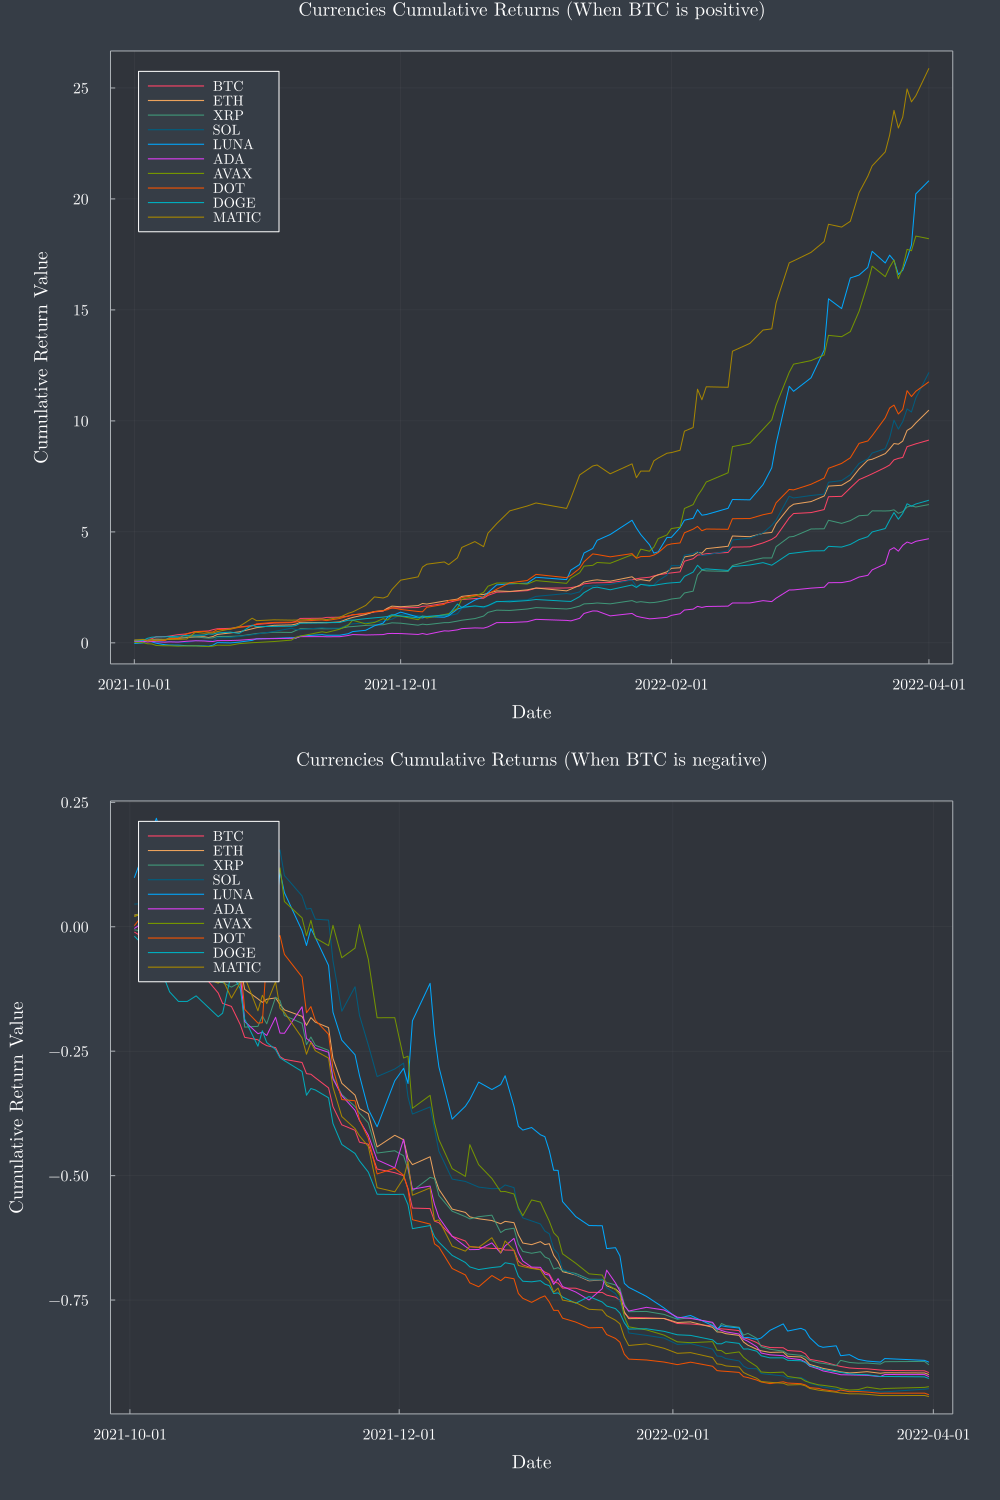

In [113]:
PosPLT = begin
    plot(title="Currencies Cumulative Returns (When BTC is positive)",
        legend=:topleft, xlab="Date", ylab="Cumulative Return Value")
    PosDates = Total6MonthData[1].Timestamp[PReturnsINDX]
    for i ∈ 1:10
        plot!(PosDates, TotalPosCumRetData[i], label=Currencies[i])
    end
    plot!(topmargin=5mm, bottommargin=5mm, rightmargin=10mm, leftmargin=10mm, size=(1000, 600))
end

NegPLT = begin
    plot(title="Currencies Cumulative Returns (When BTC is negative)",
        legend=:topleft, xlab="Date", ylab="Cumulative Return Value")
    NegDates = Total6MonthData[1].Timestamp[NReturnsINDX]
    for i ∈ 1:10
        plot!(NegDates, TotalNegCumRetData[i], label=Currencies[i])
    end
    plot!(topmargin=5mm, bottommargin=5mm, rightmargin=10mm, leftmargin=10mm, size=(1000, 600))
end

plot(PosPLT, NegPLT, layout=(2, 1), size=(1000, 1500))

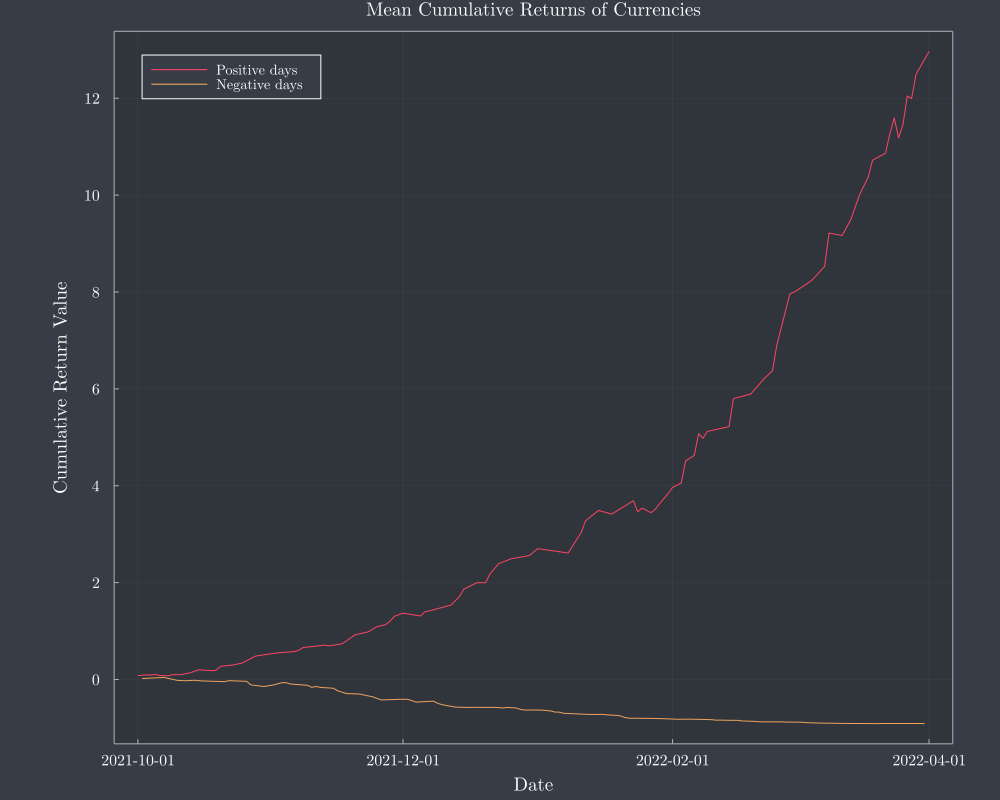

In [114]:
ComparePLT = begin
    PosDates = Total6MonthData[1].Timestamp[PReturnsINDX]
    NegDates = Total6MonthData[1].Timestamp[NReturnsINDX]
    plot(title="Mean Cumulative Returns of Currencies",
        legend=:topleft, xlab="Date", ylab="Cumulative Return Value")
    plot!(PosDates, MeanPosDays, lab="Positive days")
    plot!(NegDates, MeanNegDays, lab="Negative days")
    plot!(rightmargin=10mm, leftmargin=15mm, size=(1000, 800))
end

## ***Problem 3:***

### Defining required functions

In [174]:
function GetPortfolioReturn(TotData::Vector{DataFrame}, Weight::Vector)
    Returns = [prod(1 .+ GetReturns(data)) for data ∈ TotData]
    return Weight' * Returns
end
CovarianceMatrix(TotData::Vector{DataFrame}, Weight::Vector) = Weight' * cov(hcat(([GetReturns(data) for data ∈ TotData])...)) * Weight

CovarianceMatrix (generic function with 1 method)

### Exporting required data

In [69]:
Weights = collect(multiexponents(3, 20)) / 20;

Currencies = String["BTC", "ETH", "XRP"];
TotalP3Data = [GetData(Curr, 12) for Curr ∈ Currencies];

In [182]:
PortfolioReturn = [GetPortfolioReturn(TotalP3Data, Weights[i]) for i ∈ 1:length(Weights)];
PortfolioVariance = [CovarianceMatrix(TotalP3Data, Weights[i]) for i ∈ 1:length(Weights)];
SharpeRatio = PortfolioReturn ./ .√PortfolioVariance;

In [506]:
ExportData = DataFrame("Weights" => Weights, "PortfolioReturn" => PortfolioReturn, "PortfolioVariance" => PortfolioVariance, "SharpeRatio" => SharpeRatio)
CSV.write("Problem3ExportData.csv", ExportData);

### Plotting the results

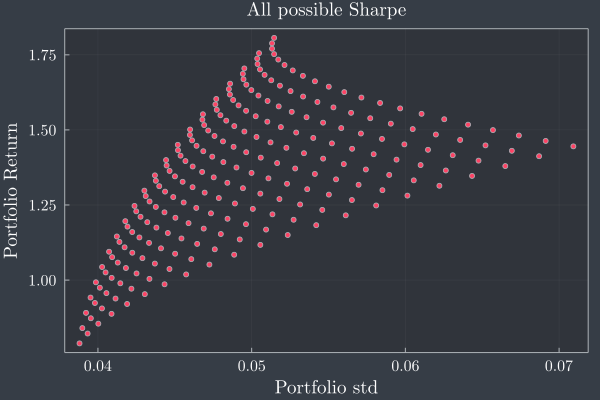

In [282]:
scatter(.√PortfolioVariance, PortfolioReturn,
    xlab="Portfolio std", ylab="Portfolio Return",
    title = "All possible Sharpe", ms = 3)

In [480]:
MaxRet = findmax(PortfolioReturn)[2]
LowestRiskINX = findmin(.√PortfolioVariance)[2]
LRWeight = Weights[LowestRiskINX]
BestWeight = Weights[MaxRet]
display(L"\text{The best weight is %$BestWeight}")
display(L"\text{The lowest risk is %$LRWeight}")

L"$\text{The best weight is [0.0, 1.0, 0.0]}$"

L"$\text{The lowest risk is [1.0, 0.0, 0.0]}$"

## ***Problem 4***

### Defining required functions

In [490]:
MANewPrices(df::DataFrame, Steps::Integer) = [mean(df."Close (USD)"[i:i+Steps]) for i ∈ 1:100]
MANewPrices(Prices::Vector, Steps::Integer) = [mean(Prices[i:i+Steps]) for i ∈ 1:100]

MANewPrices (generic function with 3 methods)

### Exporting required data

In [497]:
data = GetData("BTC", 7);
TotalDates = data.Timestamp[1:100];
MovingAvg5D = MANewPrices(data, 5);
MovingAvg30D = MANewPrices(data, 30);
BuySignals = count(x -> MovingAvg5D[x] > MovingAvg30D[x], 1:100);
SellSignals = count(x -> MovingAvg5D[x] <= MovingAvg30D[x], 1:100);

### Plotting the results

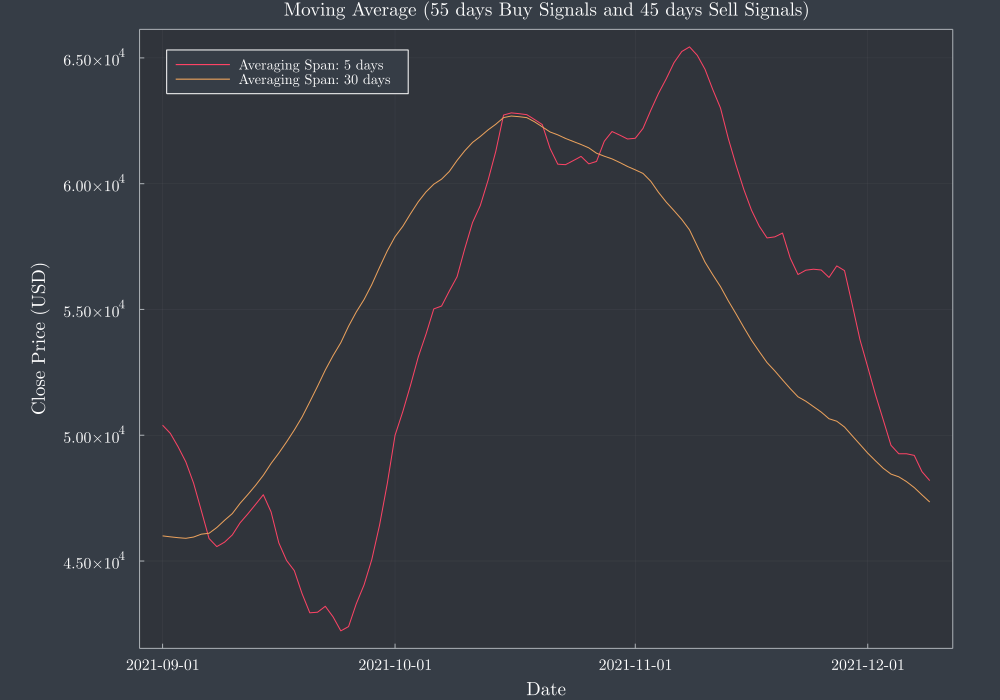

In [498]:
plot(TotalDates, MovingAvg5D, label="Averaging Span: 5 days")
plot!(TotalDates, MovingAvg30D, label="Averaging Span: 30 days")
plot!(xlab = "Date", ylab = "Close Price (USD)", title = "Moving Average ($BuySignals days Buy Signals and $SellSignals days Sell Signals)",
    legend = :topleft, size = (1000, 700),rightmargin=10mm, leftmargin=10mm)

In [499]:
BuySignalsINX = findall(x -> MovingAvg5D[x] > MovingAvg30D[x], 1:100)
data."Close (USD)"[BuySignalsINX] *= 1.05
NewPrices = data."Close (USD)"
MovingAvg5D = MANewPrices(NewPrices, 5);
MovingAvg30D = MANewPrices(NewPrices, 30);
BuySignals = count(x -> MovingAvg5D[x] > MovingAvg30D[x], 1:100);
SellSignals = count(x -> MovingAvg5D[x] <= MovingAvg30D[x], 1:100);

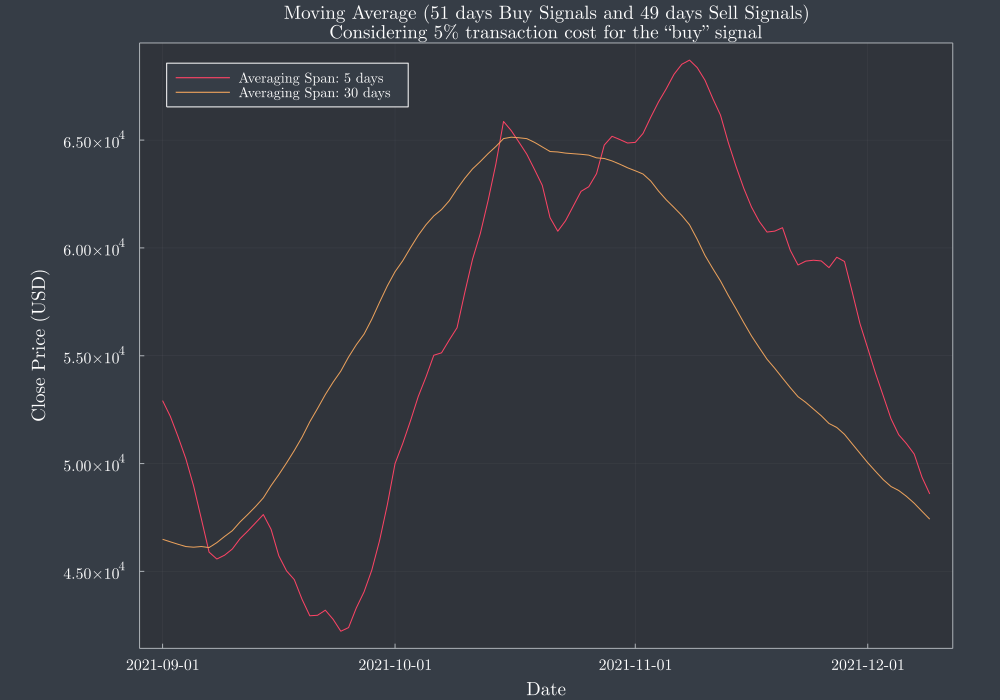

In [500]:
plot(TotalDates, MovingAvg5D, label="Averaging Span: 5 days")
plot!(TotalDates, MovingAvg30D, label="Averaging Span: 30 days")
plot!(xlab="Date", ylab="Close Price (USD)", title="Moving Average ($BuySignals days Buy Signals and $SellSignals days Sell Signals)\nConsidering 5% transaction cost for the “buy” signal",
    legend=:topleft, size=(1000, 700), rightmargin=10mm, leftmargin=10mm)

## ***Probelm 5:***

### Defining required functions

In [275]:
function IsPrime(N::Integer)
    if N <= 1
        return false
    end
    check = 0
    for n ∈ 1:N
        if N % n == 0
            check += 1
        end
    end
    if check > 2
        return false
    else
        return true
    end
end

IsPrime (generic function with 1 method)

## ***Probelm 6:***

### Defining required functions

In [283]:
function GetFullData(TikName::String)
    Data = digital_currency_daily(TikName, "USD", datatype="csv")[1][:, [1, 2, 3, 4, 5, 10, 11]]
    CurrDF = DataFrame("Timestamp" => Date.(Data[:, 1]),
        "Open (USD)" => Float64.(Data[:, 2]),
        "High (USD)" => Float64.(Data[:, 3]),
        "Low (USD)" => Float64.(Data[:, 4]),
        "Close (USD)" => Float64.(Data[:, 5]),
        "Volume" => Float64.(Data[:, 6]),
        "Market Cap (USD)" => Float64.(Data[:, 7]))
    return sort(CurrDF, "Timestamp")
end

GetFullData (generic function with 1 method)

### Exporting required data

In [402]:
Currencies = String["BTC", "ETH", "XRP", "ADA", "DOGE"];
FullData = [GetFullData(Curr) for Curr ∈ Currencies];
TimeLine = FullData[1].Timestamp;
SumDailyRets = sum(hcat([GetReturns(data) for data ∈ FullData]...), dims=2);
SumAbsDailyRets = abs.(SumDailyRets);
MonthsIndices = [findall(x -> x == i, month.(FullData[1].Timestamp)) for i ∈ 1:12];

### Plotting the results

Depending on the amount of return we can find the best day for trading. But also we can consider a very negative return as a good day for trading. I show the results for both considerations.

In [403]:
display(L"\text{The best day for trading is %$(TimeLine[findmax(SumDailyRets)[2]])}")

L"$\text{The best day for trading is 2021-01-28}$"

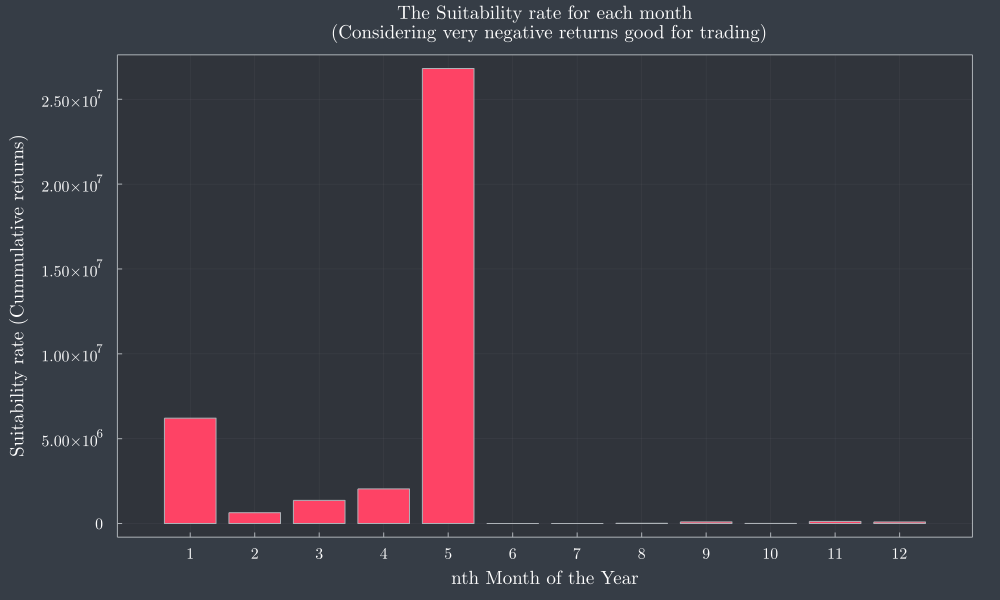

In [409]:
bar([prod(1 .+ SumAbsDailyRets[MonthsIndices[i]]) for i ∈ 1:12], xticks=1:12)
plot!(title="The Suitability rate for each month\n (Considering very negative returns good for trading)",
    xlab="nth Month of the Year", ylab="Suitability rate (Cummulative returns)", bottommargin =5mm, topmargin=5mm, rightmargin=5mm, leftmargin=5mm, size = (1000, 600))

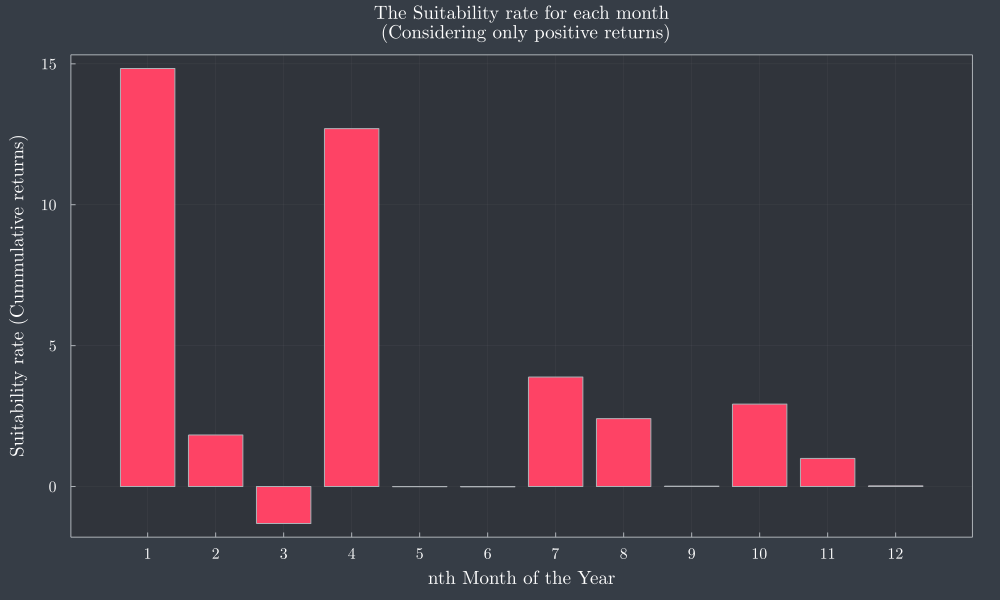

In [411]:
bar([prod(1 .+ SumDailyRets[MonthsIndices[i]]) for i ∈ 1:12], xticks=1:12)
plot!(title="The Suitability rate for each month\n (Considering only positive returns)",
    xlab="nth Month of the Year", ylab="Suitability rate (Cummulative returns)", bottommargin=5mm, topmargin=5mm, rightmargin=5mm, leftmargin=5mm, size=(1000, 600))

As we can see the first month of the year is the best time for trading(buying) but if we consider very negative return good for trading, we should consider the 5th month of the year.

## ***Problem 7:***

In [459]:
function RPSGetWinner(P1Input::Int, P2Input::Int)
    if P1Input == P2Input
        return "Drawn"
    elseif P1Input == P2Input + 1 || P1Input == P2Input - 2
        return "Lost"
    elseif P1Input == P2Input - 1 || P1Input == P2Input + 2
        return "Won"
    end
end
ComputerPlayer() = sample(1:3, weights([1 / 6, 1 / 3, 1 / 2]))

ComputerPlayer (generic function with 1 method)

In [464]:
readprompt("Hi Player1! Welcome to the RPS Game. You will playe 5 rounds. to continue please press enter...")
res = String[]
for i ∈ 1:5
    answer = readprompt("Enter the number of desired option: Rock[1] Peper[2] Scissor[3]")
    P1Choice = parse(Int, answer)
    P2Choice = rand(1:3)
    push!(res, RPSGetWinner(P1Choice, P2Choice))
end
print("The result of the game:\n$res")

The result of the game:
["Drawn", "Drawn", "Lost", "Won", "Drawn"]

In [467]:
res = String[]
for i ∈ 1:1000
    P1Choice = ComputerPlayer()
    P2Choice = rand(1:3)
    push!(res, RPSGetWinner(P1Choice, P2Choice))
end

In [468]:
Wons, Losts, Draws = count(x -> x == "Won", res), count(x -> x == "Lost", res), count(x -> x == "Drawn", res)
print("The result of the game:\n$Wons won, $Losts lost, $Draws drawn")

The result of the game:
325 won, 340 lost, 335 drawn

As I can see there is no superiority